# Model Risk Pipeline

This notebook aims at demonstrating how one might employ the default pipeline for ML tasks. Hyperparameter optimization relies on `hyperopt` library, we expect to add `optuna` support in the future.

__Inputs:__

1. Dataset

__Ouputs:__

1. Optimal pipeline structure, as obtained by `hyperopt`
2. Optimal model

## 1. Technicals

In [1]:
import time
import json
import numpy as np
import pandas as pd
import sklearn
from hyperopt import hp
from collections import OrderedDict
import matplotlib.pyplot as plt
import scikitplot as skplt

from modules.utils import gini_score
from modules.defaults import get_default_modules
from modules.pipeline import PipeHPOpt

from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

In [2]:
seed = 42

## 2. Import Dataset

In [3]:
X_train = pd.read_parquet('../datasets/01_german/samples/X_train.parquet')
y_train = pd.read_parquet('../datasets/01_german/samples/y_train.parquet').target

X_test  = pd.read_parquet('../datasets/01_german/samples/X_test.parquet')
y_test  = pd.read_parquet('../datasets/01_german/samples/y_test.parquet').target

In [4]:
with open('../datasets/01_german/factors.json') as json_file:
    factors_dict = json.load(json_file)

## 3. Define Modules

All the modules that might be part of the pipeline should be defined below (or import them):

In [5]:
# get default modules
pipe_modules = get_default_modules()

## 4. Define Pipeline

### 4.1. Структура Pipeline

Определим структуру самого пайплайна. Словесное описание:
    
1. Энкодинг категориальных переменных:
    + OneHotEncoder
    + WoE
3. Feature Engineering:
    + PCA
    + Kernel PCA
    + Isomap
    + UMAP
    + Combine with Reference (feature multiplication)
    + _passthrough_
4. Feature Selection:
    + RecursiveFeatureAddition
    + SequentialFeatureSelector
    + SmartCorrelatedSelection
    + _passthrough_
4. Resampling:
    + Randomised Undersampling (RUS)
    + Randomised Oversampling  (ROS)
    + Synthetic Minority Oversampling Technique (SMOTE)
    + Adaptive Synthetic (ADASYN)
    + _passthrough_
5. LightGBM

А так это будет выражаться в коде:

In [6]:
pipe_params = OrderedDict()

pipe_params['cat_encoding'] = hp.choice('cat_encoding', ['OneHot', 'WoE'])
pipe_params['missing_vals'] = hp.choice('missing_vals', ['skip', 'MeanImp', 'MedImp']) # , 'ModeImp', 'RandomImp', 'KNNImp', 'IterImp'
pipe_params['imbalance']    = hp.choice('imbalance',    ['skip', 'RUS', 'ROS', 'SMOTE', 'ADASYN'])
pipe_params['feat_eng']     = hp.choice('feat_eng',     ['skip', 'PCA', 'kPCA', 'Isomap', 'UMAP']) # , 'CombWRef' excluded, since it takes too much time
pipe_params['feat_sel']     = hp.choice('feat_sel',     ['skip', 'SeqFearSel', 'RecFeatAdd', 'SmartSel']) # 'SelShuffl' is omitted, since it might drop all Xs
pipe_params['lgbm']         = 'lgbm'

pipe_params
# hp.choice() -- unstable, low quality (SHAP, IV, feat_importance, ...) 

OrderedDict([('cat_encoding', <hyperopt.pyll.base.Apply at 0x1ed05b10bc8>),
             ('missing_vals', <hyperopt.pyll.base.Apply at 0x1ed05b11108>),
             ('imbalance', <hyperopt.pyll.base.Apply at 0x1ed05b11788>),
             ('feat_eng', <hyperopt.pyll.base.Apply at 0x1ed05b11d48>),
             ('feat_sel', <hyperopt.pyll.base.Apply at 0x1ed05b0c288>),
             ('lgbm', 'lgbm')])

Заметим, что 'skip' позволяет игнорировать соответствующий шаг в пайплайне. Названия типа `"onehot"` должны совпадать с названиями в словаре `modules`, который мы определили на Шаге 3.

### 4.2. Гиперпараметры модулей

В следующий словарь добавляем гиперпараметры каждого из модулей, которые мы хотим оптимизировать. Названия строятся следующи образом:

`<Название модуля>__<название параметра>`

Например, чтобы задать параметр `num_leaves` модуля lgbm, трубуется добваить значение с ключем `lgbm__num_leaves`.

In [7]:
set_params = {
    # OneHotEncoder does not need hyperparams
    # RecFeatAdd might be redefined to receive a correct estimator
    # PCA
    # 'DimRed__PCA__n_components':      hp.choice('PCA__n_components',      np.arange(2, 11)),
    'DimRed__PCA__n_components':      hp.quniform('DimRed__PCA__n_components', low=2, high=11, q=1),
    'DimRed__PCA__whiten':            hp.choice('DimRed__PCA__whiten',            [True, False]),
    'DimRed__PCA__svd_solver':        hp.choice('DimRed__PCA__svd_solver',        ['full', 'arpack', 'auto', 'randomized']),
    
    # kPCA
    # 'DimRed__kPCA__n_components':     hp.choice('kPCA__n_components',     np.arange(5, 11)),
    'DimRed__kPCA__n_components':     hp.quniform('DimRed__kPCA__n_components', low=5, high=11, q=1),
    'DimRed__kPCA__kernel':           hp.choice('DimRed__kPCA__kernel', ['linear', 'poly', 'rbf', 'sigmoid', 'cosine', 'precomputed']),
    
    # Isomap
    # 'DimRed__Isomap__n_neighbors':    hp.choice('Isomap__n_neighbors',    np.arange(2, 11)),
    # 'DimRed__Isomap__n_components':   hp.choice('Isomap__n_components',   np.arange(2, 5)),
    'DimRed__Isomap__n_neighbors':    hp.quniform('DimRed__Isomap__n_neighbors', low=2, high=5, q=1),
    'DimRed__Isomap__n_components':   hp.quniform('DimRed__Isomap__n_components', low=2, high=11, q=1),
    'DimRed__Isomap__path_method':    hp.choice('DimRed__Isomap__path_method',    ['auto', 'FW', 'D']),
    
    # UMAP
    # 'DimRed__UMAP__n_neighbors':      hp.choice('UMAP__n_neighbors',      np.arange(2, 11)),
    # 'DimRed__UMAP__n_components':     hp.choice('UMAP__n_components',     np.arange(2, 11)),
    # 'DimRed__UMAP__min_dist':         hp.choice('UMAP__min_dist',         np.arange(0.05, 1, 0.05)),
    'DimRed__UMAP__n_neighbors':      hp.quniform('DimRed__UMAP__n_neighbors', low=2, high=11, q=1),
    'DimRed__UMAP__n_components':     hp.quniform('DimRed__UMAP__n_components', low=2, high=11, q=1),
    'DimRed__UMAP__min_dist':         hp.uniform('DimRed__UMAP__min_dist', low=.05, high=1),
    
    # LightGBM
    # 'lgbm__learning_rate':            hp.choice('lgbm__learning_rate',    np.arange(0.05, 0.31, 0.05)),
    # 'lgbm__num_leaves':               hp.choice('lgbm__num_leaves',       np.arange(5, 16, 1, dtype=int)),
    # 'lgbm__reg_alpha':                hp.choice('lgbm__reg_alpha',        np.arange(0, 16, 1, dtype=int)),
    # 'lgbm__reg_lambda':               hp.choice('lgbm__reg_lambda',       np.arange(0, 16, 1, dtype=int)),
    'lgbm__learning_rate':            hp.uniform('lgbm__learning_rate', low=.05, high=.31),
    'lgbm__num_leaves':               hp.quniform('lgbm__num_leaves', low=5, high=32, q=1),
    'lgbm__reg_alpha':                hp.uniform('lgbm__reg_alpha', low=0, high=16),
    'lgbm__reg_lambda':               hp.uniform('lgbm__reg_lambda', low=0, high=16),
    'lgbm__n_estimators':             100
}

Чтобы параметры можно было оптимизировать, модули должны иметь метод `.set_params()`.

### 4.3. Подстановка оптимизационной задачи

In [8]:
# technicals — define minimization task
pipe_para = dict()
pipe_para['pipe_params']    = pipe_params
pipe_para['set_params']     = set_params
pipe_para['loss_func']      = lambda y, pred: -sklearn.metrics.roc_auc_score(y, pred)
# pipe_para['loss_func']      = lambda y, pred: -sklearn.metrics.log_loss(y, pred)

In [9]:
# %%capture --no-stdout
hpoptimizer = PipeHPOpt(X_train, y_train, modules=pipe_modules, mode='kfold', n_folds = 4, seed=seed)
lgb_opt, trials = hpoptimizer.process(space=pipe_para, trials=Trials(), algo=tpe.suggest, max_evals=10)

 20%|█████████▌                                      | 2/10 [00:01<00:06,  1.21trial/s, best loss: -0.7528224187469961]

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\sklearn\manifold\_isomap.py:302: UserWarning: The number of connected components of the neighbors graph is 14 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\s

 40%|███████████████████▏                            | 4/10 [00:06<00:10,  1.81s/trial, best loss: -0.7617518101628442]

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\sklearn\manifold\_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\sklearn\manifold\_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\sklearn\manifold\_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit

 50%|████████████████████████                        | 5/10 [01:01<01:44, 20.95s/trial, best loss: -0.7617518101628442]

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\sklearn\manifold\_isomap.py:302: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\si

 60%|████████████████████████████▊                   | 6/10 [01:04<00:59, 14.84s/trial, best loss: -0.7617518101628442]

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\sklearn\manifold\_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\sklearn\manifold\_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\sklearn\manifold\_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit

 80%|██████████████████████████████████████▍         | 8/10 [01:36<00:28, 14.25s/trial, best loss: -0.7617518101628442]

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\sklearn\manifold\_isomap.py:302: UserWarning: The number of connected components of the neighbors graph is 14 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\s

100%|███████████████████████████████████████████████| 10/10 [01:45<00:00, 10.52s/trial, best loss: -0.7617518101628442]


## 5. Results Analysis

In [10]:
hpoptimizer.get_best_params()
best_mdl = hpoptimizer.get_best_model()

c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\sklearn\manifold\_isomap.py:302: UserWarning: The number of connected components of the neighbors graph is 19 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\users\antonmarkov\01-studies\01-phd\year-3\model-risks\credit_scoring_project\lib\site

In [11]:
y_train_pred = best_mdl.predict_proba(X_train)
y_test_pred = best_mdl.predict_proba(X_test)

### 5.1. Ginis: Train vs. Test

In [12]:
gini_score(y_train, y_train_pred[:, 1])
gini_score(y_test, y_test_pred[:, 1])

Gini: 0.7698468664405169
Gini: 0.5670152662579635


0.5670152662579635

#### ROC

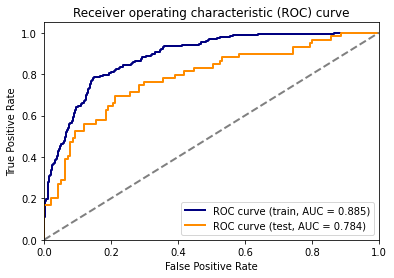

In [13]:
hpoptimizer.plot_roc(X_train, y_train, X_test, y_test, mdl=best_mdl)

#### Gain

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

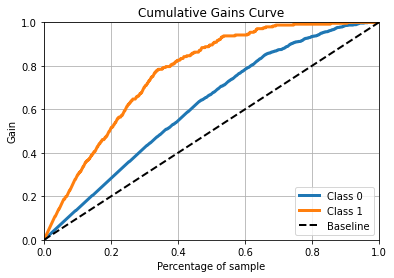

In [14]:
skplt.metrics.plot_cumulative_gain(y_train, y_train_pred)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

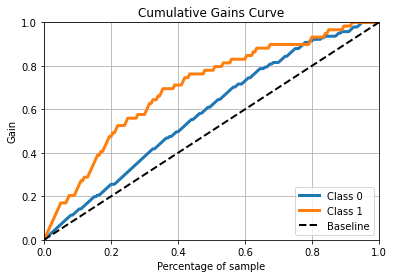

In [15]:
skplt.metrics.plot_cumulative_gain(y_test, y_test_pred)

#### Lift

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

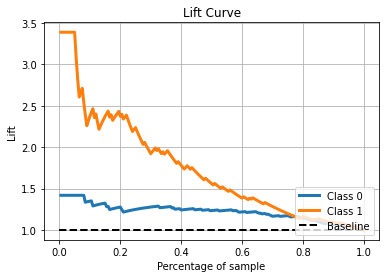

In [16]:
skplt.metrics.plot_lift_curve(y_test, y_test_pred)

#### KS Statistic

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

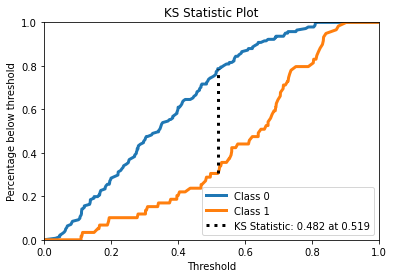

In [17]:
skplt.metrics.plot_ks_statistic(y_test, y_test_pred)

#### Precision-Recall

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

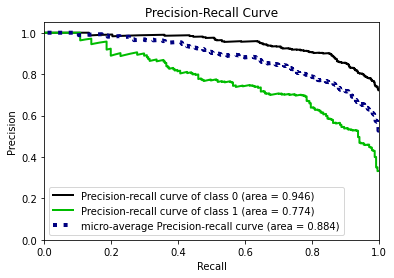

In [18]:
skplt.metrics.plot_precision_recall(y_train, y_train_pred)

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

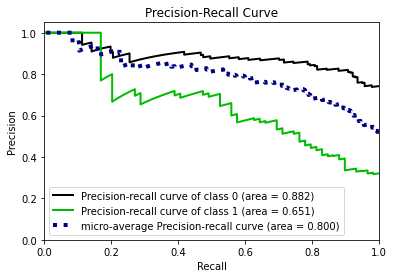

In [19]:
skplt.metrics.plot_precision_recall(y_test, y_test_pred)

### 5.2. Calibration

<AxesSubplot:title={'center':'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>

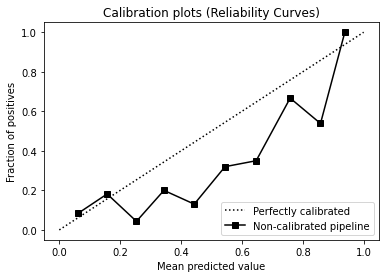

In [20]:
skplt.metrics.plot_calibration_curve(y_test,
                                     [y_test_pred],
                                     ['Non-calibrated pipeline'])

### 5.3. HyperOpt Convergence

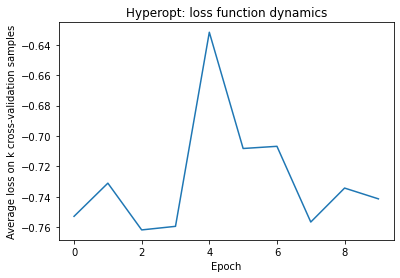

In [21]:
hpoptimizer.plot_convergence()